In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Processing
We'll analyze the player's attributes, their in-game effectiveness and cost.

In [7]:
df_p = pd.read_csv('prices_database.csv', index_col='Unnamed: 0', parse_dates=['date', 'added_date'])
stats_cols = ['num_games', 'avg_goals', 'avg_assists'] 
for col in stats_cols:
    if col == 'num_games':
        df_p[col] = df_p[col].str.replace(',', '')
    df_p[col] = np.where(df_p[col] == '-', 0, df_p[col])
    df_p[col] = pd.to_numeric(df_p[col])
df_p.head(2)

,player_name,quality,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,num_games,avg_goals,avg_assists,date,price
0,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,12719,0.69,0.41,2018-09-20,0
1,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,12719,0.69,0.41,2018-09-21,0


### Feature Engineering

**Guideline:**
player_ID, player_name are only kept for identification purposes.

1. quality variable is dropped.
2. we use the position variable to construct a general_position variable s.t:
    - Attacker: ST, CF, LW, LF, LM, RW, RF, RM, CAM
    - Midfielder: CM, CDM
    - Defender: RWB, RB, CB, LB, LWB
3. date and added_date will be used to construct the following variables: 
    - days_available: number of days the player has been available on FIFA
    - days_since_launch: number of days since the game was released
4. league and nationality will be used to construct the following:
    - popular_nation: a binary variable indicating if the player's nation is 'popular' or not
    - popular_league: a binary variable indicating if the player's team competes in a 'popular' league or not


In [8]:
print('We currently have {} variables for {} observations.'.format(df_p.shape[1], df_p.shape[0]))

We currently have 59 variables for 373261 observations.


#### Step 1
We drop quality.

In [9]:
# drop quality
df_p.drop(['quality'], axis = 1, inplace = True)

#### Step 2
Create the general_position variable.

In [10]:
attacker_positions = ['LM', 'LW', 'LF', 'CF', 'ST', 'RM', 'RW', 'RF', 'CAM']
midfielder_positions = ['CDM', 'CM']
defender_positions = ['LWB', 'LB', 'CB', 'RWB', 'RB']
df_p['general_position'] = np.nan
df_p['general_position'] = np.where(df_p['position'].isin(attacker_positions), 'Attacker', df_p.general_position)
df_p['general_position'] = np.where(df_p['position'].isin(midfielder_positions), 'Midfielder', df_p.general_position)
df_p['general_position'] = np.where(df_p['position'].isin(defender_positions), 'Defender', df_p.general_position)

#### Step 3
We engineer days_available, days_since_launch and weekday variable.

In [11]:
df_p['days_available'] = (df_p.date - df_p.added_date).dt.days
df_p['days_since_launch'] = (df_p.date - df_p.date.min()).dt.days
df_p['weekday'] = df_p['date'].dt.weekday_name

#### Step 4
We construct the popular_nation and popular_league variables.

In [12]:
df_p[['resource_id', 'revision', 'nationality']].groupby('resource_id').last().groupby('nationality').count().sort_values(by=['revision'], ascending = False).head(10)

,revision
nationality,
Spain,359
France,292
Brazil,277
Germany,213
Argentina,202
England,194
Italy,190
Portugal,138
Holland,135


In [13]:
popular_nations = list(df_p[['resource_id', 'revision', 'nationality']].groupby('resource_id').last().groupby('nationality').count().sort_values(by=['revision'], ascending = False).reset_index()['nationality'][:10])
df_p['popular_nations'] = np.where(df_p.nationality.isin(popular_nations), 1, 0)
print('{}% of our players are from popular nations.'.format(round(100 * df_p.popular_nations.sum() / df_p.shape[0], 2)))

64.52% of our players are from popular nations.


In [14]:
df_p[['resource_id', 'revision', 'league']].groupby('resource_id').last().groupby('league').count().sort_values(by=['revision'], ascending = False).head(10)

,revision
league,
Premier League,537
LaLiga Santander,462
Serie A TIM,407
Bundesliga,391
Ligue 1 Conforama,271
Icons,210
Liga NOS,155
Süper Lig,97
Eredivisie,81


In [15]:
popular_leagues = list(df_p[['resource_id', 'revision', 'league']].groupby('resource_id').last().groupby('league').count().sort_values(by=['revision'], ascending = False).reset_index()['league'][:10])
df_p['popular_leagues'] = np.where(df_p.league.isin(popular_leagues), 1, 0)
print('{}% of our players are from popular leagues.'.format(round(100 * df_p.popular_leagues.sum() / df_p.shape[0], 2)))

83.07% of our players are from popular leagues.


# Market Overview
How have the prices changed since release? How does the price of 84s fluctuate for each of the Top 5 leagues?

In [16]:
def league_price_plots(overall):
    market_dfs = {}
    fig, ax = plt.subplots(figsize=(20,10))
    for league in popular_leagues[:5]:
        market_dfs[league] = df_p[df_p.league == league]
        market_dfs[league] = market_dfs[league][(market_dfs[league].price > 0) & (market_dfs[league].overall == overall)]
        market_dfs[league] = market_dfs[league].groupby('date').price.min()
        plt.plot(market_dfs[league].index, market_dfs[league][:])

    fig.legend(popular_leagues[:5])
    plt.title('Price of {}s for each of the top 5 Leagues'.format(overall), fontsize=20, loc='left')

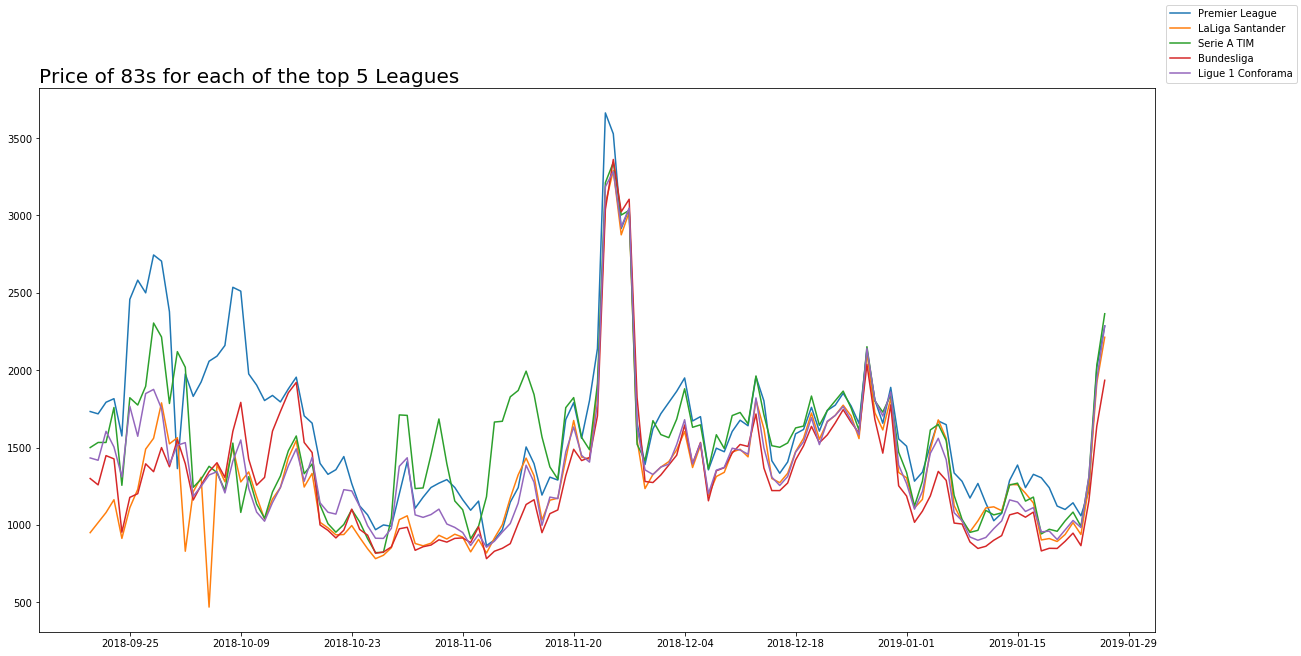

In [17]:
league_price_plots(83)

In [18]:
def nation_price_plots(overall):
    market_dfs = {}
    fig, ax = plt.subplots(figsize=(20,10))
    for nation in popular_nations[:5]:
        market_dfs[nation] = df_p[df_p.nationality == nation]
        market_dfs[nation] = market_dfs[nation][(market_dfs[nation].price > 0) & (market_dfs[nation].overall == overall)]
        market_dfs[nation] = market_dfs[nation].groupby('date').price.min()
        plt.plot(market_dfs[nation].index, market_dfs[nation][:])

    fig.legend(popular_nations[:5])
    plt.title('Price of {}s for each of the top 5 Nations'.format(overall), fontsize=20, loc='left')

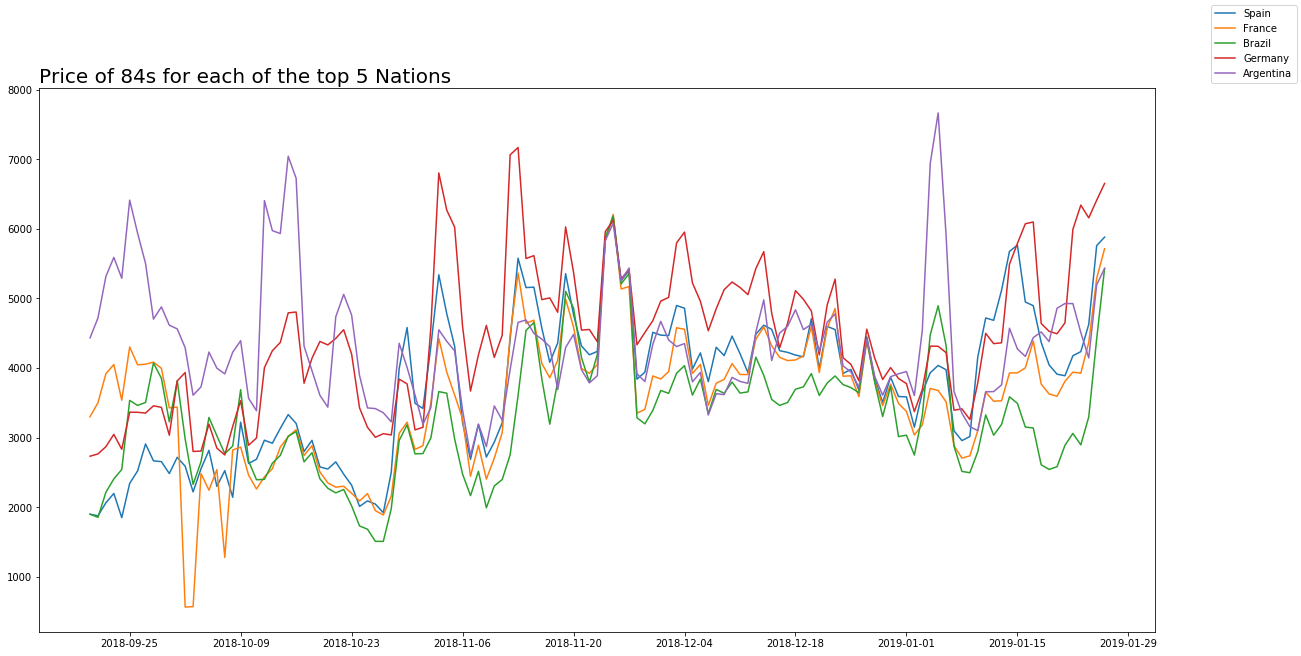

In [19]:
nation_price_plots(84)

## Complementary Goods
How do prices of complementary players react to the release of a Flashback Card?

The aim of the Complementary Goods analysis is to determine the reaction of complementary cards to the release of a Flashback Card. For instance, how did the price of Germand Dortmund cards react to the release of Gotze? It's important to distinguish whether the reaction was due to the SBC requirements or the actual link. 

In [20]:
df_p[(df_p.revision == 'Flashback SBC') & (df_p.player_name != 'Pedro')].groupby('resource_id').first()

,player_name,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,num_games,avg_goals,avg_assists,date,price,general_position,days_available,days_since_launch,weekday,popular_nations,popular_leagues
resource_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50372884,Zlatan Ibrahimovic,Flashback SBC,92,LA Galaxy,Major League Soccer,Sweden,ST,37,195,95,5,2019-01-11,84.0,82,84,91.0,85,44,94,96,91,99,94.0,92,94,98,89,94,97,87.0,89,82,92,89,82,92,55.0,32,99,45,59,38,92.0,80,71,99,99,Right,Med,Low,4,5,377703,0.66,0.27,2019-01-10,0,Attacker,-1,112,Thursday,0,1
50474649,Carlos Tévez,Flashback SBC,90,Buenos Aires,SAF,Argentina,CF,34,171,76,3,2019-01-04,88.0,90,86,88.0,86,83,83,86,89,90,92.0,93,92,99,83,88,88,80.0,84,77,73,84,70,80,60.0,47,75,48,71,69,85.0,64,85,85,87,Right,Med,Low,3,4,352784,0.43,0.25,2019-01-03,0,Attacker,-1,105,Thursday,1,0
50505557,Kevin-Prince Boateng,Flashback SBC,87,Sassuolo,Serie A TIM,Ghana,CM,31,186,86,3,2018-11-30,80.0,81,78,83.0,79,70,81,87,81,85,84.0,84,81,89,82,88,71,83.0,80,79,75,87,83,86,78.0,79,82,65,86,82,84.0,84,75,86,91,Right,High,Med,4,4,103485,0.22,0.19,2018-11-29,0,Midfielder,-1,70,Thursday,0,1
50509872,Javier Hernández,Flashback SBC,87,West Ham United,Premier League,Mexico,ST,30,175,73,3,2018-11-19,87.0,91,82,85.0,85,89,92,87,82,89,85.0,93,91,81,71,80,80,70.0,76,70,56,71,61,73,35.0,29,89,23,32,28,66.0,92,73,59,66,Right,Med,Low,3,3,149046,0.61,0.33,2018-11-18,0,Attacker,-1,59,Sunday,0,1
67162914,Wayne Rooney,Flashback SBC,90,D.C. United,Major League Soccer,England,CF,33,176,83,4,2019-01-24,91.0,91,91,87.0,76,89,95,92,83,99,90.0,85,88,94,87,92,90,86.0,87,81,86,86,87,89,60.0,61,81,56,60,43,85.0,82,74,87,90,Right,Med,High,4,3,1134,0.47,0.26,2019-01-23,0,Attacker,-1,125,Wednesday,1,1
67255394,Dani Alves,Flashback SBC,90,Paris Saint-Germain,Ligue 1 Conforama,Brazil,RB,35,172,68,4,2018-12-03,90.0,88,91,89.0,89,92,81,91,89,84,81.0,84,69,98,88,77,79,85.0,81,89,77,85,82,83,85.0,87,79,79,87,90,75.0,90,84,62,88,Right,High,Low,3,4,282445,0.04,0.08,2018-12-02,0,Defender,-1,73,Sunday,1,1
67255624,Juanfran,Flashback SBC,87,Atlético Madrid,LaLiga Santander,Spain,RB,33,181,71,3,2018-10-12,87.0,79,92,85.0,82,70,91,87,86,82,64.0,75,59,75,58,54,72,83.0,80,90,66,86,74,89,87.0,87,67,85,92,91,83.0,74,87,80,85,Right,High,Med,3,4,909723,0.01,0.05,2018-10-11,0,Defender,-1,21,Thursday,1,1
67280697,Daniel Sturridge,Flashback SBC,88,Liverpool,Premier League,England,ST,29,180,76,3,2018-11-23,90.0,86,93,85.0,80,69,85,87,86,88,87.0,87,89,88,84,78,80,77.0,83,70,77,81,70,70,27.0,25,82,12,28,14,81.0,90,72,84,77,Left,Med,Low,2,4,396195,0.61,0.33,2018-11-22,0,Attacker,-1,63,Thursday,1,1
67301182,Mario Götze,Flashback SBC,87,Borussia Dortmund,Bundesliga,Germany,CF,26,176,75,4,2018-11-03,81.0,86,76,89.0,90,87,86,93,86,87,84.0,90,86,78,75,98,88,87.0,90,81,75,91,85,84,64.0,70,55,68,57,60,70.0,60,77,71,60,Right,Med,Med,4,4,693146,0.34,0.32,2018-11-02,0,Attacker,-1,43,Friday,1,1


Of the Flashback cards displayed above, Pedro will be removed as his SBC wasn't the same as the others. 

In [21]:
flashback_cards = df_p[(df_p.revision == 'Flashback SBC') & (df_p.player_name != 'Pedro')].groupby('resource_id').first().index

We will construct a dataframe for each Flashback Card, made up of the data of each complementary player. 

In [22]:
def complementary_data(res_id, num_players):
    """
    Function to plot the price changes for complementary players of a given card.
    Argument:
        res_id: the player's resource_id
        num_players: number of complementary players we wish to plot
    """
    player = df_p[df_p.resource_id == res_id].iloc[0]
    nat = player.nationality
    club = player.club
    date = player.added_date
    league = player.league
    comp_data = df_p[((df_p.date > date - timedelta(3)) & (df_p.date < date + timedelta(3))) & ((df_p.nationality == nat) | (df_p.club == club)) & (df_p.league == league)]
    comp_data = comp_data[comp_data.resource_id != res_id]
    comp_data['rel_day'] = np.nan
    for i in range(-2,3):
        comp_data['rel_day'] = np.where(comp_data.date == date - timedelta(i), -i, comp_data.rel_day)
        
    or_prices = {}
    for i in comp_data.resource_id.unique():
        try:
            or_prices[i] = int(comp_data[(comp_data.resource_id == i) & (comp_data.date == date - timedelta(2))].price.iloc[0])
        except:
            print('New player added exception.')
    
    or_prices = pd.DataFrame.from_dict(or_prices, orient='index', columns = ['o_price'])
    comp_data = comp_data.merge(or_prices.reset_index(), left_on='resource_id', right_on='index', how='left')
    comp_data['price_change'] = comp_data.price / comp_data.o_price * 100
    comp_data.drop('index', axis=1, inplace=True)
    players = comp_data.resource_id.unique()[:num_players]
    fig, ax = plt.subplots(figsize=(20,10))
    player_names = []
    for player in players:
        data = comp_data[comp_data.resource_id == player][['rel_day', 'price_change', 'player_name']]
        plt.plot(data.rel_day, data.price_change)
        player_names.append(data[data.rel_day == 0].player_name.iloc[0])
    fig.legend(player_names)
    plt.xticks(np.arange(-2,3))
    plt.title('Price Changes of Complementary Players for {}.'.format(df_p[df_p.resource_id == res_id].player_name.iloc[0], fontsize=20, loc='left'))

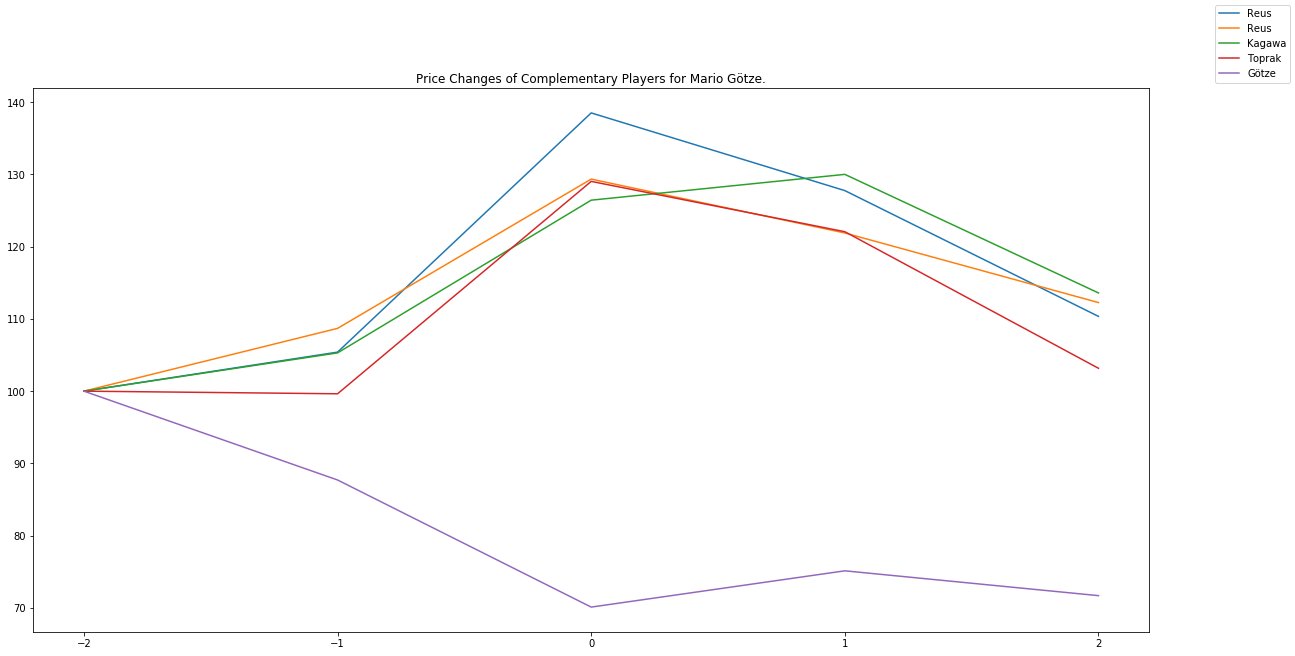

In [23]:
complementary_data(67301182, 5)

# Attacking Effectiveness

Which attributes play the biggest role in goal contribution? Is composure or finishing more important? How does goal contribution vary by overall?

In [24]:
df_ae = df_p[df_p.general_position == 'Attacker'].groupby('resource_id').last().reset_index()

In [25]:
df_ae.head(2)

,resource_id,player_name,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,num_games,avg_goals,avg_assists,date,price,general_position,days_available,days_since_launch,weekday,popular_nations,popular_leagues
0,51,Shearer,Icon,91,Icons,Icons,England,ST,48,182,78,0,2018-09-19,81.0,82,80,78.0,71,71,87,82,76,88,93.0,92,95,94,86,93,94,77.0,76,77,86,82,63,81,52.0,44,94,28,65,55,85.0,88,84,88,80,Right,High,Med,3,2,124526,0.89,0.32,2019-01-26,606212,Attacker,129,128,Saturday,1,1
1,241,Giggs,Icon,92,Icons,Icons,Wales,LM,44,179,71,0,2018-09-19,90.0,91,90,91.0,82,82,84,91,94,88,80.0,88,83,74,76,83,86,90.0,86,94,83,91,88,90,44.0,46,57,37,43,46,67.0,61,89,60,57,Left,High,Med,2,3,86523,0.37,0.35,2019-01-26,657078,Attacker,129,128,Saturday,0,1


In [26]:
df_ae['goal_contribution'] = df_ae.avg_goals + df_ae.avg_assists

df_ae['num_games_group'] = np.nan
df_ae['num_games_group'] = np.where(df_ae.num_games < 100, '<100', df_ae.num_games_group)
df_ae['num_games_group'] = np.where((df_ae.num_games < 500) & (df_ae.num_games >= 100), '100-500', df_ae.num_games_group)
df_ae['num_games_group'] = np.where((df_ae.num_games < 1000) & (df_ae.num_games >= 500), '500-1000', df_ae.num_games_group)
df_ae['num_games_group'] = np.where((df_ae.num_games < 5000) & (df_ae.num_games >= 1000), '1000-5000', df_ae.num_games_group)
df_ae['num_games_group'] = np.where((df_ae.num_games < 10000) & (df_ae.num_games >= 5000), '5000-10000', df_ae.num_games_group)
df_ae['num_games_group'] = np.where(df_ae.num_games >= 10000, '>10000', df_ae.num_games_group)

Text(0,1,'Attackers: Average Goal Contribution by Overall')

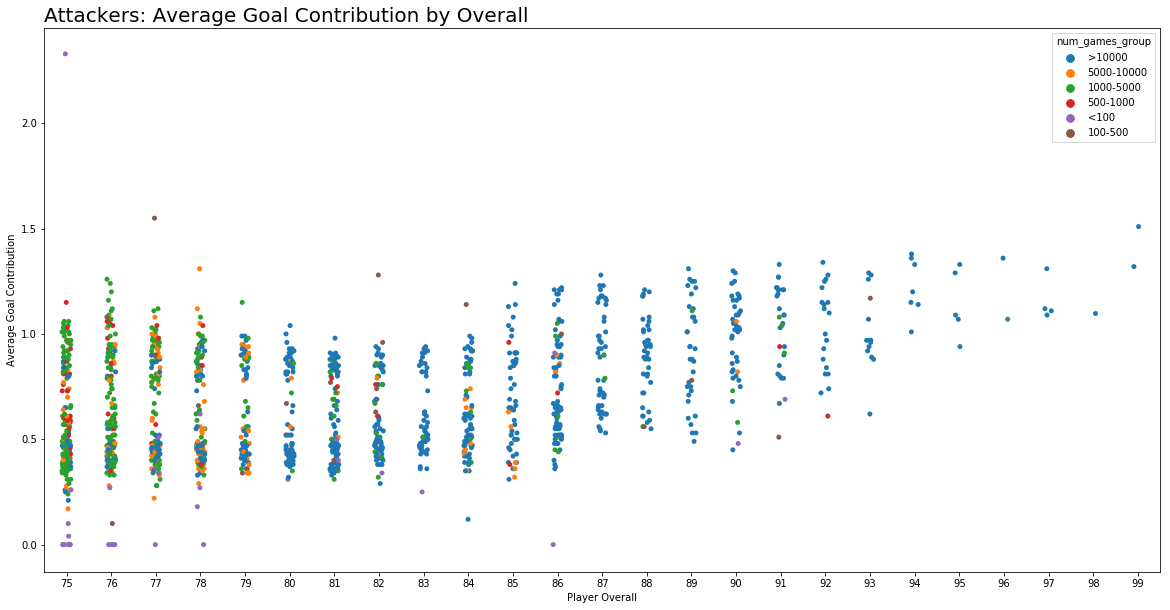

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.stripplot(x=df_ae.overall, y=df_ae.goal_contribution, hue=df_ae.num_games_group, jitter=True)
plt.xlabel('Player Overall')
plt.ylabel('Average Goal Contribution')
plt.title('Attackers: Average Goal Contribution by Overall', fontsize=20, loc='left')

Players with less than 1000 games will be deemed to be outliers and removed from our Attacking Effectiveness analysis. 

In [28]:
df_ae = df_ae[df_ae.num_games >= 10000]

Text(0,1,'Attackers: Average Goal Contribution by Overall and Number of Games')

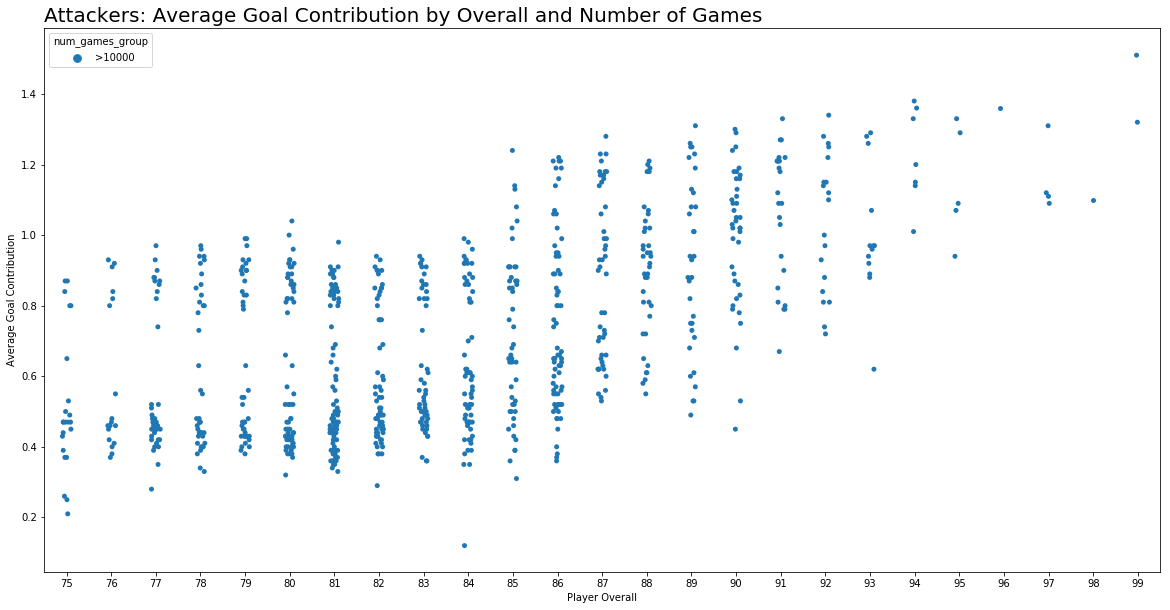

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.stripplot(x=df_ae.overall, y=df_ae.goal_contribution, hue=df_ae.num_games_group, jitter=True)
plt.xlabel('Player Overall')
plt.ylabel('Average Goal Contribution')
plt.title('Attackers: Average Goal Contribution by Overall and Number of Games', fontsize=20, loc='left')

We will now focus on players in the top 6 leagues.

In [30]:
df_ae.sort_values(by='goal_contribution').head()

,resource_id,player_name,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,num_games,avg_goals,avg_assists,date,price,general_position,days_available,days_since_launch,weekday,popular_nations,popular_leagues,goal_contribution,num_games_group
1331,67276769,Antonio Valencia,IF,84,Manchester United,Premier League,Ecuador,RM,33,180,83,2,2018-11-21,87.0,84,88,82.0,73,79,85,83,82,84,72.0,78,64,91,70,68,59,79.0,73,82,68,84,73,72,81.0,85,63,79,84,81,81.0,70,83,81,82,Right,High,High,2,3,724794,0.04,0.08,2019-01-26,30961,Attacker,66,128,Saturday,0,1,0.12,>10000
307,190577,Blanco,Normal,75,Portland Timbers,Major League Soccer,Argentina,LM,30,168,64,1,2018-09-19,77.0,76,78,77.0,89,79,76,77,75,65,71.0,70,67,77,74,76,61,71.0,74,69,60,75,69,59,32.0,33,66,30,22,32,70.0,65,85,59,79,Right,Med,Med,3,3,11811,0.10,0.11,2019-01-26,585,Attacker,129,128,Saturday,1,1,0.21,>10000
764,226376,Romero Gamarra,Normal,75,New York Red Bulls,Major League Soccer,Paraguay,CAM,23,171,68,1,2018-09-19,82.0,84,81,77.0,89,82,64,74,78,70,65.0,69,65,68,67,51,61,72.0,75,65,62,76,72,64,47.0,40,39,61,44,40,57.0,56,75,55,41,Left,High,Med,3,3,10949,0.10,0.15,2019-01-26,658,Attacker,129,128,Saturday,0,1,0.25,>10000
595,211119,Pedro Santos,Normal,75,Columbus Crew SC,Major League Soccer,Portugal,RM,30,173,65,1,2018-09-19,86.0,87,85,76.0,83,78,73,75,76,75,70.0,73,68,75,70,64,65,70.0,70,71,74,72,62,80,57.0,49,62,59,59,54,64.0,72,77,57,63,Left,High,High,5,4,10682,0.11,0.15,2019-01-26,626,Attacker,129,128,Saturday,1,1,0.26,>10000
541,207537,Lukaku,Normal,77,Lazio,Serie A TIM,Belgium,LM,24,177,86,2,2018-09-19,91.0,89,93,79.0,78,79,78,80,80,76,61.0,61,54,76,66,57,53,70.0,68,79,46,74,66,53,71.0,77,62,66,74,72,80.0,74,76,84,74,Left,High,Med,4,4,228885,0.12,0.16,2019-01-26,700,Attacker,129,128,Saturday,1,1,0.28,>10000


Text(0,1,'Attackers: Average Goal Contribution by Overall in every League')

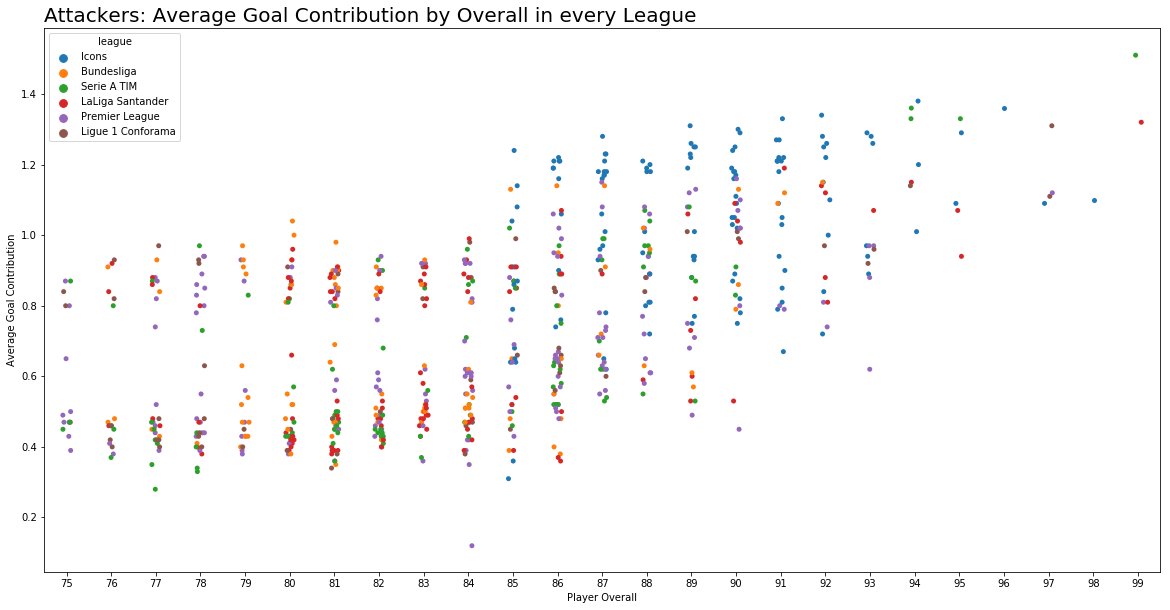

In [31]:
df_ae = df_ae[df_ae.league.isin(popular_leagues[:6])]
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.stripplot(x=df_ae.overall, y=df_ae.goal_contribution, hue=df_ae.league, jitter=True)
plt.xlabel('Player Overall')
plt.ylabel('Average Goal Contribution')
plt.title('Attackers: Average Goal Contribution by Overall in every League', fontsize=20, loc='left')

In [32]:
df_ae[df_ae.league == 'Premier League'].sort_values(by='goal_contribution', ascending=False).head(5)

,resource_id,player_name,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,num_games,avg_goals,avg_assists,date,price,general_position,days_available,days_since_launch,weekday,popular_nations,popular_leagues,goal_contribution,num_games_group
1325,67261943,Sergio Agüero,UCL LIVE,90,Manchester City,Premier League,Argentina,ST,30,173,70,4,2018-11-09,85.0,89,80,90.0,86,92,90,90,90,91,91.0,94,95,89,83,86,84,78.0,85,71,73,83,64,84,29.0,24,76,31,20,12,75.0,83,78,75,66,Right,High,Med,4,4,181348,0.77,0.39,2019-01-26,1524569,Attacker,78,128,Saturday,1,1,1.16,>10000
264,188567,Aubameyang,Normal,87,Arsenal,Premier League,Gabon,ST,29,187,80,3,2018-09-19,94.0,93,95,80.0,76,70,86,82,79,84,84.0,89,87,81,78,86,76,75.0,77,77,74,77,64,78,37.0,48,79,27,25,36,70.0,79,76,76,43,Right,Med,Low,4,4,7306198,0.77,0.38,2019-01-26,123210,Attacker,129,128,Saturday,0,1,1.15,>10000
1447,84074647,Aubameyang,PL POTM,89,Arsenal,Premier League,Gabon,ST,29,187,80,3,2018-11-09,95.0,93,96,83.0,78,72,89,85,81,87,86.0,91,89,82,79,88,77,79.0,81,81,77,81,67,82,39.0,50,83,28,26,37,73.0,82,79,79,44,Right,Med,Low,4,4,705136,0.74,0.39,2019-01-26,0,Attacker,78,128,Saturday,0,1,1.13,>10000
73,153079,Agüero,Normal,89,Manchester City,Premier League,Argentina,ST,30,173,70,4,2018-09-19,84.0,88,80,89.0,86,91,89,89,89,90,89.0,92,93,88,82,85,83,76.0,83,70,72,81,63,82,28.0,24,74,30,20,12,73.0,81,76,73,65,Right,High,Med,4,4,8210368,0.73,0.39,2019-01-26,142469,Attacker,129,128,Saturday,1,1,1.12,>10000
1513,117633497,Kevin De Bruyne,TOTY,97,Manchester City,Premier League,Belgium,CAM,27,181,70,4,2019-01-08,87.0,88,85,96.0,87,84,99,99,94,97,96.0,97,92,99,99,91,88,99.0,99,99,89,99,97,91,78.0,78,71,87,75,66,92.0,74,99,88,89,Right,High,High,5,4,115073,0.67,0.45,2019-01-20,2243928,Attacker,12,122,Sunday,1,1,1.12,>10000


### Top Goal Contributors for Attackers in Top 6 Leagues

In [33]:
for league in popular_leagues[:6]:
    print(league)
    top_d = df_ae[df_ae.league == league].sort_values(by='goal_contribution', ascending=False).head(5)
    for i in range(1, 6):
        print('{}: {}, Overall: {}, Revision: {}.'.format(i, list(top_d.player_name)[i-1], list(top_d.overall)[i-1], list(top_d.revision)[i-1]))

Premier League
1: Sergio Agüero, Overall: 90, Revision: UCL LIVE.
2: Aubameyang, Overall: 87, Revision: Normal.
3: Aubameyang, Overall: 89, Revision: PL POTM.
4: Agüero, Overall: 89, Revision: Normal.
5: Kevin De Bruyne, Overall: 97, Revision: TOTY.
LaLiga Santander
1: Lionel Messi, Overall: 99, Revision: TOTY.
2: Suárez, Overall: 91, Revision: Normal.
3: Messi, Overall: 94, Revision: Normal.
4: Luis Suárez, Overall: 92, Revision: IF.
5: Suárez, Overall: 92, Revision: Normal.
Serie A TIM
1: Cristiano Ronaldo, Overall: 99, Revision: TOTY.
2: Ronaldo, Overall: 94, Revision: Normal.
3: Ronaldo, Overall: 95, Revision: Normal.
4: Ronaldo, Overall: 94, Revision: OTW.
5: Patrick Cutrone, Overall: 89, Revision: FUT Future Stars.
Bundesliga
1: Robert Lewandowski, Overall: 92, Revision: TOTGS.
2: Timo Werner, Overall: 86, Revision: SIF.
3: Timo Werner, Overall: 87, Revision: TIF.
4: Lewandowski, Overall: 90, Revision: Normal.
5: Werner, Overall: 85, Revision: IF.
Ligue 1 Conforama
1: Kylian Mbap

### Top Scorers for Attackers in Top 6 Leagues

In [34]:
for league in popular_leagues[:6]:
    print(league)
    top_d = df_ae[df_ae.league == league].sort_values(by='avg_goals', ascending=False).head(5)
    for i in range(1, 6):
        print('{}: {}, Overall: {}, Revision: {}.'.format(i, list(top_d.player_name)[i-1], list(top_d.overall)[i-1], list(top_d.revision)[i-1]))

Premier League
1: Sergio Agüero, Overall: 90, Revision: UCL LIVE.
2: Aubameyang, Overall: 87, Revision: Normal.
3: Kane, Overall: 89, Revision: Normal.
4: Mohamed Salah, Overall: 90, Revision: SIF.
5: Aubameyang, Overall: 89, Revision: PL POTM.
LaLiga Santander
1: Lionel Messi, Overall: 99, Revision: TOTY.
2: Suárez, Overall: 91, Revision: Normal.
3: Diego Costa, Overall: 86, Revision: Halloween.
4: Luis Suárez, Overall: 92, Revision: IF.
5: Messi, Overall: 94, Revision: Normal.
Serie A TIM
1: Cristiano Ronaldo, Overall: 99, Revision: TOTY.
2: Ronaldo, Overall: 94, Revision: Normal.
3: Ronaldo, Overall: 94, Revision: OTW.
4: Ronaldo, Overall: 95, Revision: Normal.
5: Patrick Cutrone, Overall: 89, Revision: FUT Future Stars.
Bundesliga
1: Robert Lewandowski, Overall: 92, Revision: TOTGS.
2: Lewandowski, Overall: 90, Revision: Normal.
3: Robert Lewandowski, Overall: 91, Revision: IF.
4: Timo Werner, Overall: 87, Revision: TIF.
5: Werner, Overall: 85, Revision: IF.
Ligue 1 Conforama
1: Ky

### Top Assists for Attackers in Top 6 Leagues

In [35]:
for league in popular_leagues[:6]:
    print(league)
    top_d = df_ae[df_ae.league == league].sort_values(by='avg_assists', ascending=False).head(5)
    for i in range(1, 6):
        print('{}: {}, Overall: {}, Revision: {}.'.format(i, list(top_d.player_name)[i-1], list(top_d.overall)[i-1], list(top_d.revision)[i-1]))

Premier League
1: Kevin De Bruyne, Overall: 97, Revision: TOTY.
2: Kevin De Bruyne, Overall: 93, Revision: FUTmas SBC.
3: Agüero, Overall: 89, Revision: Normal.
4: De Bruyne, Overall: 91, Revision: Normal.
5: Eden Hazard, Overall: 93, Revision: SIF.
LaLiga Santander
1: Lionel Messi, Overall: 99, Revision: TOTY.
2: Messi, Overall: 94, Revision: Normal.
3: Luis Suárez, Overall: 92, Revision: IF.
4: Griezmann, Overall: 89, Revision: Normal.
5: Suárez, Overall: 91, Revision: Normal.
Serie A TIM
1: Insigne, Overall: 89, Revision: IF.
2: Dries Mertens, Overall: 88, Revision: IF.
3: Simeone, Overall: 78, Revision: Normal.
4: Dybala, Overall: 89, Revision: Normal.
5: Paulo Dybala, Overall: 90, Revision: TOTGS.
Bundesliga
1: Volland, Overall: 81, Revision: Normal.
2: Timo Werner, Overall: 87, Revision: TIF.
3: Timo Werner, Overall: 86, Revision: SIF.
4: Werner, Overall: 85, Revision: IF.
5: Burgstaller, Overall: 80, Revision: Normal.
Ligue 1 Conforama
1: Neymar Jr, Overall: 94, Revision: TOTGS.

Text(0,1,'Attackers: Average Goal Contribution by Price')

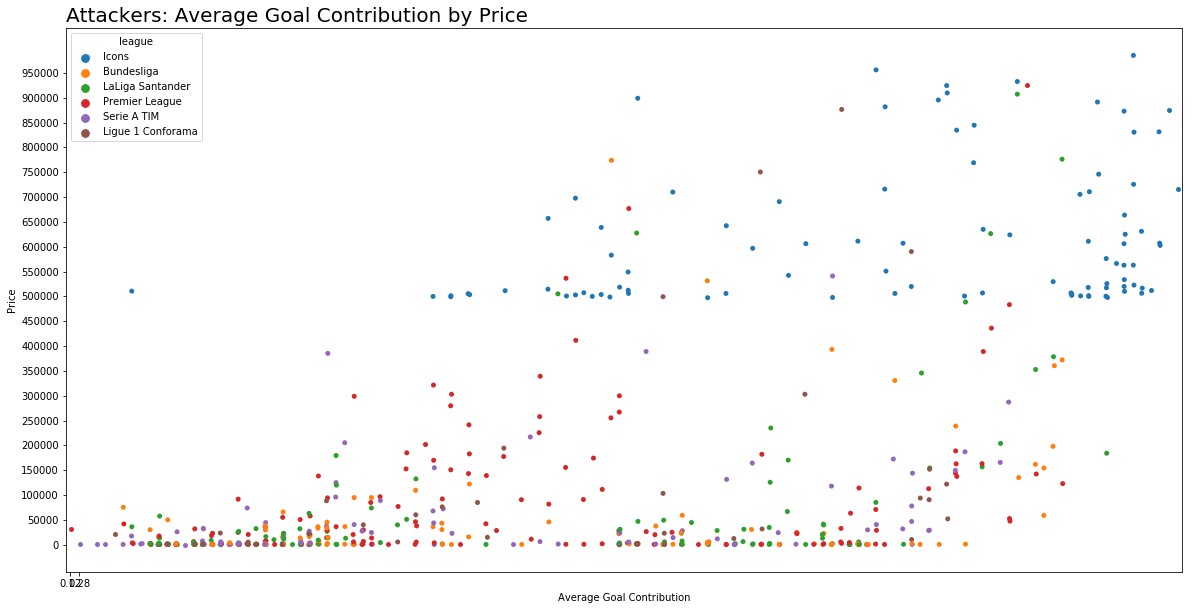

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.stripplot(x='goal_contribution', y='price', hue='league', data=df_ae[(df_ae.price > 0) & (df_ae.price < 1000000)], jitter=True)
plt.xlabel('Average Goal Contribution')
plt.ylabel('Price')
plt.xticks(np.arange(0, 2, 1))
plt.yticks(np.arange(0, 1000000, 50000))
plt.title('Attackers: Average Goal Contribution by Price', fontsize=20, loc='left')